## Loading the MNIST dataset          

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

#### Loading the dataset

In [2]:
(trainX, trainy), (testX, testY) = mnist.load_data()

#### Summarize the loaded dataset

In [3]:
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


#### Plot the first few images

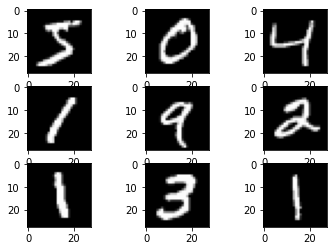

In [4]:
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()

## Developing a baseline model
#### Involves developing infrastructure for the test harness so that any model can be evaluated, and establihses a baseline for model performance
#### Test harness = loading dataset, prepping dataset, definiton of the model, evaluating the model, presentation of results

### Load dataset

In [5]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # reshape dataset to have a single channel
    # all images are 28x28 pixels, images are grayscale
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # there are 10 classes that are represented as unique integers
    # one hot encode target values
    # this transforms the integer into a 10 element binary vector
    # with 1 as the index of the class value and 0 for all others
        # to_categorical() allows us to do this
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


### Prepare pixel data

In [6]:
# Know: pixel values are unsigned integers from 0 to 255 (black to white)

# scale pixels
def prep_pixels(train, test):
    # convert data types from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0 # 255 is max value!
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# prep_pixels() needs to be called to prepare pixel values before modeling

### Define the model (CNN)

In [7]:
# two main parts: feature extraction front end (convolutional and pooling layers) and classifier backend that predicts

# define cnn model
def define_model():
    model = Sequential()
    
    # all layers use the ReLU activation function and He weight initialization scheme
    # single convolutional layers with small filter size (3,3), modest number of filters (32)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    # next layer is a max pooling layer
    model.add(MaxPooling2D((2, 2)))
    # then the filter maps are flattened to provide features for the classifier
    model.add(Flatten())
    # another layer that interprets the feature with 100 nodes
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9) # learning rate = 0.01, momentum = 0.9
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Evaluate the model

In [8]:
# evaluation will be done through five-fold cross-validation
# each test set will be ~12,000 examples
# training dataset is shuffled before being split
# the baseline model will be trained for 10 training epochs with default batch size of 32 examples
# evaluate a model using k-fold cross-validation

def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

### Presenting the results

In [9]:
# two key things: diagnostics of learning behavior of the model during training and estimation of the model performance

# plot diagnostic learning curves
    # useful when analyzing if a model is overfitting, underfitting, or is a good fit
def summarize_diagnostics(histories):
    # blue lines indicate model performance on the training dataset, orange lines are performance on the test dataset
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

### Actually running the test harness

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

## Running it

> 98.558
> 98.625
> 98.642
> 98.775
> 98.642


<ipython-input-9-6c92cfb51043>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-9-6c92cfb51043>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


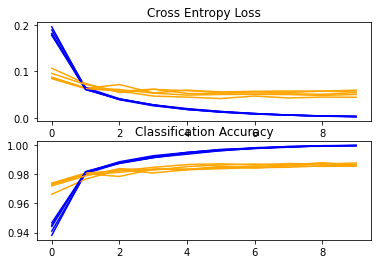

Accuracy: mean=98.648 std=0.070, n=5


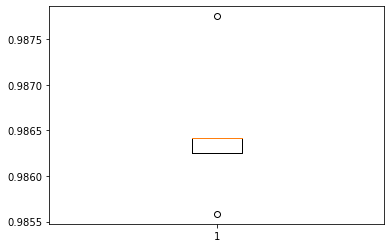

In [11]:
run_test_harness()

## Finalizing the model and making predictions

### Save the final model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    model.save('final_model.h5')
 
run_test_harness()

## Evaluating the final model 
### load final model, evaluate on test dataset

In [ ]:
from tensorflow.keras.models import load_model
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # load model
    model = load_model('final_model.h5')
    # evaluate model on test dataset
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
 
# entry point, run the test harness
run_test_harness()

## Making predictions

In [ ]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.png')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	digit = model.predict_classes(img)
	print(digit[0])

# entry point, run the example
run_example()